## Кейс A/B теста - Приложение доставки

**Предыстория:** 

Я работаю аналитиком в приложении по доставке продуктов. Команда внедрила в приложение умную систему рекомендации товаров – предполагается, что такая система поможет пользователям эффективнее работать с приложением и лучше находить необходимые товары.

Чтобы проверить эффективность системы рекомендаций, был проведен АБ-тест. В группе 1 оказались пользователи с новой системой рекомендаций, в группе 0 пользователи со старой версией приложения, где нет рекомендации товаров.

**Моя задача** – оценить, смогла ли новая система рекомендаций принести пользу бизнесу и пользователям приложения. Для этого нужно выбрать метрики, которые отвечают за качество сервиса, и статистически сравнить эти метрики в двух группах.

**Результат моей работы** – аналитическое заключение с ответом на вопрос, стоит ли включать новую систему рекомендаций на всех пользователей.

* ab_users_data – история заказов пользователей, в этой таблице есть информация о том, какие заказы создавали и отменяли пользователи
* ab_orders – подробная информация о составе заказа, тут для каждого заказа есть список id тех продуктов, которые были включены в заказ
* ab_products – подробная информация о продуктах, их название и стоимость

## 1. Загрузка библиотек и данных

### 1.1 Загрузка библиотек

In [1]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import chi2_contingency
import requests 
from urllib.parse import urlencode 
# Игнорировать все предупреждения
import warnings
warnings.filterwarnings('ignore')

### 1.2 Загрузка данных

In [2]:
# использую api для загрузки датафрейма с пользователями
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/4qY27tJ23G_B1g'
# получаю url 
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 
# записываю файл в датафрейм
download_response = requests.get(download_url) 
ab_users = pd.read_csv(download_url, sep=',') 

In [3]:
# использую api для загрузки датафрейма с заказами
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/prdO8FDQx7lzCg'
# получаю url 
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 
# записываю файл в датафрейм 
download_response = requests.get(download_url) 
ab_orders = pd.read_csv(download_url, sep=',') 

In [4]:
# использую api для загрузки датафрейма с товарами
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/atwrlmB_wu-fHA'
# получаю url 
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 
# записываю файл в датафрейм 
download_response = requests.get(download_url) 
ab_products = pd.read_csv(download_url, sep=',')

## 2. Первый взгляд на данные

In [5]:
ab_users#.info()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1
...,...,...,...,...,...,...
4332,990,59422,create_order,2022-09-08 23:13:03.000000,2022-09-08,1
4333,1418,59439,create_order,2022-09-08 23:18:05.000000,2022-09-08,1
4334,1605,59464,create_order,2022-09-08 23:22:27.000000,2022-09-08,0
4335,1461,59487,create_order,2022-09-08 23:29:06.000000,2022-09-08,0


In [6]:
ab_orders#.info()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56.000000,"{74, 6}"
4,1259,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"
...,...,...,...
4118,59422,2022-09-08 23:13:03.000000,"{84, 8, 24}"
4119,59439,2022-09-08 23:18:05.000000,"{9, 25, 75, 30, 6}"
4120,59464,2022-09-08 23:22:27.000000,"{60, 41, 46}"
4121,59487,2022-09-08 23:29:06.000000,"{9, 62, 77}"


In [7]:
ab_products#.info()

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0
...,...,...,...
82,83,вафли,55.0
83,84,мандарины,90.4
84,85,варенье,200.3
85,86,кофе холодный,70.3


**Вывод** 

Для дальнейшей работы потребуется:
* в датафрейме с заказами заменить фигурные скобки и сформировать списки с id товаров;
* соединить вместе датафреймы с пользователями и заказами;
* рассчитать общую стоимость заказа сразу, чтобы не тащить все столбцы датафрейма в общий;
* разбить пользователей по группам 0 и 1.

## 3. Преобразование данных

#### 3.1 Соединю два датафрейма и изменю фигурные скобки в столбце product_ids на квадратные

In [8]:
# Создаю функцию для замены скобок и преобразования к числам
def parse_product_ids(s):
    # Удаляю фигурные скобки и разделяю по запятым
    numbers_as_strings = s.replace("{", "").replace("}", "").split(",")
    # Преобразую строки в числа
    return [int(num.strip()) for num in numbers_as_strings]

In [9]:
# Соединяю датафреймы ab_users и ab_orders
ab_users_orders = ab_users.merge(ab_orders, on = 'order_id')

In [10]:
# Заменяю скобки и делаю из строк числа
ab_users_orders['product_ids'] = ab_users_orders['product_ids'].apply(parse_product_ids)
ab_users_orders

,user_id,order_id,action,time,date,group,creation_time,product_ids
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,"[75, 22, 53, 84]"
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,2022-08-26 00:02:21.000000,"[56, 76, 39]"
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0,2022-08-26 00:02:27.000000,"[76, 34, 41, 38]"
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0,2022-08-26 00:02:56.000000,"[74, 6]"
4,966,1258,cancel_order,2022-08-26 00:08:25.486419,2022-08-26,0,2022-08-26 00:02:56.000000,"[74, 6]"
...,...,...,...,...,...,...,...,...
4332,990,59422,create_order,2022-09-08 23:13:03.000000,2022-09-08,1,2022-09-08 23:13:03.000000,"[84, 8, 24]"
4333,1418,59439,create_order,2022-09-08 23:18:05.000000,2022-09-08,1,2022-09-08 23:18:05.000000,"[9, 25, 75, 30, 6]"
4334,1605,59464,create_order,2022-09-08 23:22:27.000000,2022-09-08,0,2022-09-08 23:22:27.000000,"[60, 41, 46]"
4335,1461,59487,create_order,2022-09-08 23:29:06.000000,2022-09-08,0,2022-09-08 23:29:06.000000,"[9, 62, 77]"


#### 3.2 Добавляю колонку с общей стоимостью заказа*

*чтобы не тащить третий датафрейм в общий, я с помощью функции подсчитаю стоимость каждого заказа и добавлю данные в отдельный столбец

In [11]:
# Создаю функцию для расчета общей стоимости заказа
def calculate_order_sum(product_ids):
    return ab_products[ab_products['product_id'].isin(product_ids)]['price'].sum()

In [12]:
# Применяю функцию к каждой строке и создаю новый столбец 'total_order_price'
ab_users_orders['total_order_price'] = ab_users_orders['product_ids'].apply(calculate_order_sum)
ab_users_orders

,user_id,order_id,action,time,date,group,creation_time,product_ids,total_order_price
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,"[75, 22, 53, 84]",408.7
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,2022-08-26 00:02:21.000000,"[56, 76, 39]",250.5
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0,2022-08-26 00:02:27.000000,"[76, 34, 41, 38]",310.2
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0,2022-08-26 00:02:56.000000,"[74, 6]",85.0
4,966,1258,cancel_order,2022-08-26 00:08:25.486419,2022-08-26,0,2022-08-26 00:02:56.000000,"[74, 6]",85.0
...,...,...,...,...,...,...,...,...,...
4332,990,59422,create_order,2022-09-08 23:13:03.000000,2022-09-08,1,2022-09-08 23:13:03.000000,"[84, 8, 24]",241.2
4333,1418,59439,create_order,2022-09-08 23:18:05.000000,2022-09-08,1,2022-09-08 23:18:05.000000,"[9, 25, 75, 30, 6]",518.5
4334,1605,59464,create_order,2022-09-08 23:22:27.000000,2022-09-08,0,2022-09-08 23:22:27.000000,"[60, 41, 46]",185.9
4335,1461,59487,create_order,2022-09-08 23:29:06.000000,2022-09-08,0,2022-09-08 23:29:06.000000,"[9, 62, 77]",501.9


#### 3.3 Разбиваю пользователей по группам 0 и 1, а также посмотрю на размер групп

In [13]:
Group_0 = ab_users_orders.query('group == 0')
Group_1 = ab_users_orders.query('group == 1')
print(f'Размер группы со старым приложением:{Group_0.shape[0]} человек')
print(f'Размер группы с новым приложением:{Group_1.shape[0]} человек')

Размер группы со старым приложением:1691 человек
Размер группы с новым приложением:2646 человек


## 4. Определение метрик

Я определил следующие метрики качества сервиса:

   - Размер среднего чека* - позволит нам понять, позволил ли новый алгоритм ввырастить средний чек
   - Среднее количество товаров в корзине - покажет нам, позволил ли новый алгоритм рекомендаций увеличить в среднем размер покупательской корзины
   - Доля отмененных заказов - покажет нам, с каким из алгоритмов пользователи чаще склонны передумывать после создаания заказа (возможно новый алгоритм "байтит" людей покупать ненужное, а потом они осознают и отменяют заказ, тогда по идее метрика должна быть ввыше в 1й группе)
    
*для среднего чека я буду брать в расчет только **заказы, которые не были отменены**, поскольку это позволит отразить денежный поток,  который остается в нашем сервисе. Это наиболее честное представление о том, сколько денег приносит каждый успешный заказ.

### 4.1 Анализ по среднему чеку

##### 4.1.1 Фильтрую группы от заказов, которые были созданы и затем отменены

In [14]:
# Отфильтрую отмененные заказы в группе 1
filtered_orders_1 = Group_1.groupby('order_id') \
                         .filter(lambda x: ('create_order' in x['action'].values) and \
                                 ('cancel_order' in x['action'].values))
filtered_orders_1

,user_id,order_id,action,time,date,group,creation_time,product_ids,total_order_price
48,1002,1308,create_order,2022-08-26 00:51:54.000000,2022-08-26,1,2022-08-26 00:51:54.000000,"[15, 32, 61, 30]",1025.0
49,1002,1308,cancel_order,2022-08-26 00:58:01.924112,2022-08-26,1,2022-08-26 00:51:54.000000,"[15, 32, 61, 30]",1025.0
59,1010,1319,create_order,2022-08-26 01:03:01.000000,2022-08-26,1,2022-08-26 01:03:01.000000,"[40, 38]",116.3
60,1010,1319,cancel_order,2022-08-26 01:09:22.866276,2022-08-26,1,2022-08-26 01:03:01.000000,"[40, 38]",116.3
74,1022,1335,create_order,2022-08-26 01:21:48.000000,2022-08-26,1,2022-08-26 01:21:48.000000,[46],45.5
...,...,...,...,...,...,...,...,...,...
4259,1314,56772,cancel_order,2022-09-08 14:09:53.652063,2022-09-08,1,2022-09-08 14:02:37.000000,"[50, 45, 21, 35]",485.9
4306,988,58492,create_order,2022-09-08 19:58:24.000000,2022-09-08,1,2022-09-08 19:58:24.000000,"[18, 83, 1]",263.0
4307,988,58492,cancel_order,2022-09-08 20:07:22.918779,2022-09-08,1,2022-09-08 19:58:24.000000,"[18, 83, 1]",263.0
4319,1961,59055,create_order,2022-09-08 21:49:46.000000,2022-09-08,1,2022-09-08 21:49:46.000000,"[74, 77, 26]",428.4


In [15]:
# Отфильтрую отмененные заказы в группе 0
filtered_orders_0 = Group_0.groupby('order_id') \
                         .filter(lambda x: ('create_order' in x['action'].values) and \
                                 ('cancel_order' in x['action'].values))
filtered_orders_0

,user_id,order_id,action,time,date,group,creation_time,product_ids,total_order_price
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0,2022-08-26 00:02:56.000000,"[74, 6]",85.0
4,966,1258,cancel_order,2022-08-26 00:08:25.486419,2022-08-26,0,2022-08-26 00:02:56.000000,"[74, 6]",85.0
36,993,1296,create_order,2022-08-26 00:39:26.000000,2022-08-26,0,2022-08-26 00:39:26.000000,"[35, 70, 66]",535.8
37,993,1296,cancel_order,2022-08-26 00:44:18.150475,2022-08-26,0,2022-08-26 00:39:26.000000,"[35, 70, 66]",535.8
39,995,1298,create_order,2022-08-26 00:43:47.000000,2022-08-26,0,2022-08-26 00:43:47.000000,"[1, 53, 46]",273.8
...,...,...,...,...,...,...,...,...,...
4190,1105,53610,cancel_order,2022-09-07 23:14:10.224196,2022-09-07,0,2022-09-07 23:08:08.000000,"[76, 80, 60, 87, 51, 14]",818.3
4219,1498,54938,create_order,2022-09-08 06:40:29.000000,2022-09-08,0,2022-09-08 06:40:29.000000,"[67, 77, 35]",418.8
4220,1498,54938,cancel_order,2022-09-08 06:46:29.885081,2022-09-08,0,2022-09-08 06:40:29.000000,"[67, 77, 35]",418.8
4253,1658,56612,create_order,2022-09-08 13:24:43.000000,2022-09-08,0,2022-09-08 13:24:43.000000,"[34, 26, 26, 33, 28]",303.3


In [16]:
# Сброшу индексы для обоих датафреймов
Group_1 = Group_1.reset_index(drop=True)
Group_0 = Group_0.reset_index(drop=True)

filtered_orders_1 = filtered_orders_1.reset_index(drop=True)
filtered_orders_0 = filtered_orders_0.reset_index(drop=True)

# Создаю список заказов, которые были отменены
cancelled_orders_1 = filtered_orders_1[filtered_orders_1['action'] == 'cancel_order']['order_id'].unique()
cancelled_orders_0 = filtered_orders_0[filtered_orders_1['action'] == 'cancel_order']['order_id'].unique()

# Создаю маску для строк в ab_users_orders, которые нужно исключить
mask_1 = ~Group_1['order_id'].isin(cancelled_orders_1)
mask_0 = ~Group_0['order_id'].isin(cancelled_orders_0)

# Применяю маску для фильтрации ab_users_orders
Group_1_filtered = Group_1[mask_1]
Group_0_filtered = Group_0[mask_0]

# Посмотрю на итоговые количества записей
print('Кол-во записей в группе 1:', len(Group_1))
print('Кол-во записей в группе 1 без учета отмененных:',len(Group_1_filtered))
print('Кол-во записей в группе 0:',len(Group_0))
print('Кол-во записей в группе 0 без учета отмененных:',len(Group_0_filtered))

Кол-во записей в группе 1: 2646
Кол-во записей в группе 1 без учета отмененных: 2382
Кол-во записей в группе 0: 1691
Кол-во записей в группе 0 без учета отмененных: 1527


#### 4.1.2 Считаю средний чек по чистым данным в группах

In [17]:
# Группирую записи в обеих группах по id пользователя и id заказа, суммирую стоимости заказов
agg_data_1 = Group_1_filtered.groupby(['user_id','order_id']).agg({'total_order_price':'sum'}).reset_index()
agg_data_0 = Group_0_filtered.groupby(['user_id','order_id']).agg({'total_order_price':'sum'}).reset_index()

# Рассчитываю средний чек в каждой группе
average_check_1 = round(agg_data_1['total_order_price'].sum() / len(agg_data_1),2)
average_check_0 = round(agg_data_0['total_order_price'].sum() / len(agg_data_0),2)

# Смотрю на результаты
print(f'Средний чек в группе 0: {average_check_0} руб')
print(f'Средний чек в группе 1: {average_check_1} руб')

Средний чек в группе 0: 375.07 руб
Средний чек в группе 1: 361.49 руб


**Вывод:** средний чек в группе с новым алгоритмом оказался ниже, чем в группе со старым алгоритмом

#### 4.1.3 Проверка статзначимости

Теперь проверю есть ли статистически значимые различия между средними значениями стоимости заказов у покупателей групп 0 и 1.
Для проверки использую t-тест, но сперва подготовлю данные

<Axes: xlabel='total_order_price', ylabel='Count'>

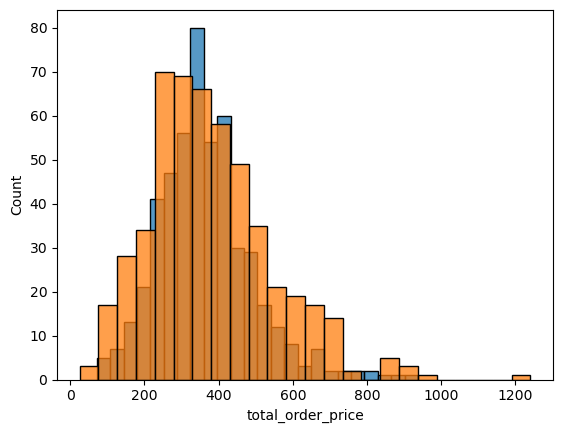

In [18]:
# Посчитаю средние значения
mean_data_1 = agg_data_1.groupby('user_id').agg({'total_order_price':'mean'}).reset_index()
mean_data_0 = agg_data_0.groupby('user_id').agg({'total_order_price':'mean'}).reset_index()

# Визуализирую распределения средних значений
sns.histplot(mean_data_1.total_order_price)
sns.histplot(mean_data_0.total_order_price)

**По расспредениям средних ввидно, что в обоих группах присутствуют выбросы. Скорректирую средние, удалив выбросы по средним чекам > 800 руб**

<Axes: xlabel='total_order_price', ylabel='Count'>

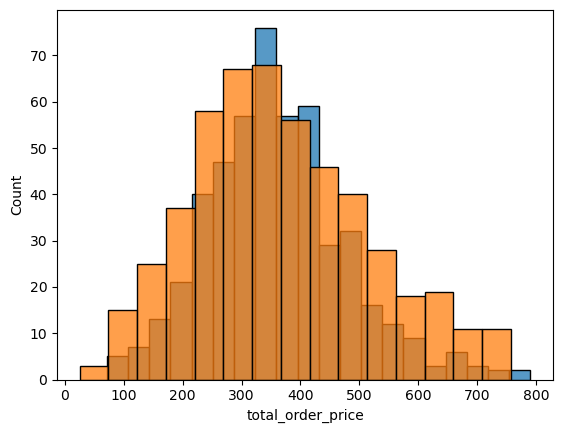

In [19]:
mean_data_1_c = agg_data_1.groupby('user_id').agg({'total_order_price':'mean'})\
                                           .reset_index().query('total_order_price <= 800')
mean_data_0_c = agg_data_0.groupby('user_id').agg({'total_order_price':'mean'})\
                                           .reset_index().query('total_order_price <= 800')
# Визуализирую распределения средних значений без выбросов
sns.histplot(mean_data_1_c.total_order_price)
sns.histplot(mean_data_0_c.total_order_price)

**Теперь распределения средних соответствуют нормальному, поэтому я могу применять t-test**

**Ho:** Средние в двух группах не отличаются.

**H1:** Средние в двух группах отличаются. 

In [20]:
t_stat, p_value = stats.ttest_ind(mean_data_1_c.total_order_price, mean_data_0_c.total_order_price)
print('P_value:' , p_value)

P_value: 0.3296240724845755


**Вывод:** Несмотря на то что средний чек в группе с новым алгоритмом ниже, статистически значимых доказательств того, что новый алгоритм привел к этому изменению, нет.

### 4.2 Анализ по среднему количеству товаров в корзине

#### 4.2.1 Отберу только созданные заказы, поскольку, теретически, наш новый алгоритм мог повлиять на добавление товаров в заказ (и не важно, что потом он был отменен)


In [21]:
# Отбираю только созданные заказы
Group_1_onlyCreate = Group_1.query('action == "create_order"') 
Group_0_onlyCreate = Group_0.query('action == "create_order"') 

# Подсчитаю количество товаров в заказах с помощью функции len
Group_1_onlyCreate['num_products'] = Group_1_onlyCreate['product_ids'].apply(len)
Group_0_onlyCreate['num_products'] = Group_0_onlyCreate['product_ids'].apply(len)

#### 4.2.2 Сгруппирую по покупателям и вычислю среднее для каждой группы

<Axes: xlabel='num_products', ylabel='Count'>

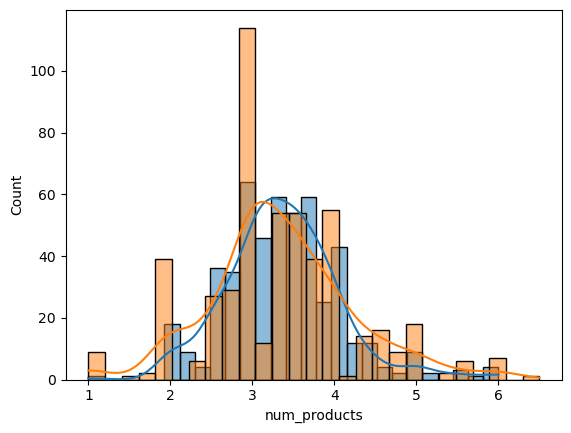

In [22]:
# Группирую по пользователям и считаю среднее товаров
Group_1_mean_products = Group_1_onlyCreate.groupby('user_id').agg({'num_products':'mean'}).reset_index()
Group_0_mean_products = Group_0_onlyCreate.groupby('user_id').agg({'num_products':'mean'}).reset_index()

# Визуализирую распределения средних
sns.histplot(Group_1_mean_products.num_products, kde = True)
sns.histplot(Group_0_mean_products.num_products, kde = True)
#  Простите, но без KDE нельзя было понять нормальное распределение или нет :)

In [23]:
# Считаю среднее количество товаров в чеке для каждой группы
mean_products_1 = round(Group_1_mean_products['num_products'].mean(),2)
mean_products_0 = round(Group_0_mean_products['num_products'].mean(),2)
print(f'Среднее количество товаров в чеке в группе 0: {mean_products_0} шт')
print(f'Среднее количество товаров в чеке в группе 1: {mean_products_1} шт')

Среднее количество товаров в чеке в группе 0: 3.35 шт
Среднее количество товаров в чеке в группе 1: 3.37 шт


#### 4.2.3 Проверка статзначимости

**Распределения средних соответствуют нормальному, поэтому я могу применять t-test**

**Ho:** Средние в двух группах не отличаются.

**H1:** Средние в двух группах отличаются.

In [24]:
t_stat, p_value = stats.ttest_ind(Group_1_mean_products.num_products, Group_0_mean_products.num_products)
print('P_value:' , p_value)

P_value: 0.7001246169604136


**Вывод:** Несмотря на незначительное увеличение среднего количества товаров в чеке в группе с новым алгоритмом, нет статистических доказательств того, что это изменение обусловлено новым алгоритмом.

### 4.3 Анализ по доле отмененных заказов

#### 4.3.1  Рассчитаю доли отмененных заказов в группах 0 и 1

In [25]:
# Считаю общее количество уникальных заказов по группам
total_orders_1 = len(Group_1['order_id'].unique())
total_orders_0 = len(Group_0['order_id'].unique())

# Считаю количество отмененных заказов
cancelled_orders_1_count = len(Group_1[Group_1['action'] == 'cancel_order']['order_id'].unique())
cancelled_orders_0_count = len(Group_0[Group_0['action'] == 'cancel_order']['order_id'].unique())

# Считаю долю отмененных заказов
cancelled_ratio_1 = (cancelled_orders_1_count / total_orders_1) * 100
cancelled_ratio_0 = (cancelled_orders_0_count / total_orders_0) * 100
print(f'Доля отмененных заказов в группе 0: {mean_products_0} %')
print(f'Доля отмененных заказов в группе 1: {mean_products_1} %')

Доля отмененных заказов в группе 0: 3.35 %
Доля отмененных заказов в группе 1: 3.37 %


#### 4.3.2 Проверка статзначимости

**Для проверки статзначимости я буду применять Хи-квадрат Пирсона, поскольку переменная категориальная (Есть отмена/нет отмены)**

**Н0:** Статистически значимых различий в долях отмененных заказов между группой 0 и группой 1 НЕТ

**Н1:** Статистически значимые различия в долях отмененных заказов между группой 0 и группой 1 ЕСТЬ

In [26]:
observed = [
    [cancelled_orders_0_count, total_orders_0 - cancelled_orders_0_count],
    [cancelled_orders_1_count, total_orders_1 - cancelled_orders_1_count]]

chi2, p_value, _, _ = chi2_contingency(observed)
print(f"p-value: {p_value}")

p-value: 0.8840344321879333


**Вывод:** Введение нового алгоритма не повлияло на долю отмененных заказов в статистически значимой степени.

## Итоговый вывод по заданию:

**По результатам проведенного эксперимента:**
1) Не выявлено статистически обоснованного влияния нового алгоритма на средний чек;
2) Не выявлено статистически обоснованного влияния нового алгоритма на среднее количество товаров в чеке;
3) Не выявлено статистически обоснованного влияния нового алгоритма на долю отмененных заказов;

На основании этого я делаю следующее заключение:

**НЕТ СТАТИСТИЧЕСКИ ДОКАЗАННЫХ ВЛИЯНИЙ НОВОГО РЕКОМЕНДАТЕЛЬНОГО АЛГОРИТМА НА ЦЕЛЕВЫЕ МЕТРИКИ, СЧИТАЮ, ЧТО ОН НЕ ОКАЖЕТ ПОЛОЖИТЕЛЬНОГО ВЛИЯНИЯ НА НАШ БИЗНЕС, ПОЭТОМУ НА ВСЕХ ПОЛЬЗОВАТЕЛЕЙ ЕГО РАСКАТЫВАТЬ НЕ НУЖНО**